<a href="https://colab.research.google.com/github/Rocco000/OncoVision/blob/main/Scripts/GAapproach1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #Connect to Google Drive

Mounted at /content/drive


Run the required scripts

Device:  cuda
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.9 MB/s eta 0:00:00
                      ❗❗❗ AUTHORIZATION REQUIRED ❗❗❗                      


Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=dd2ca95a-e81e-4be4-8121-2359eccac

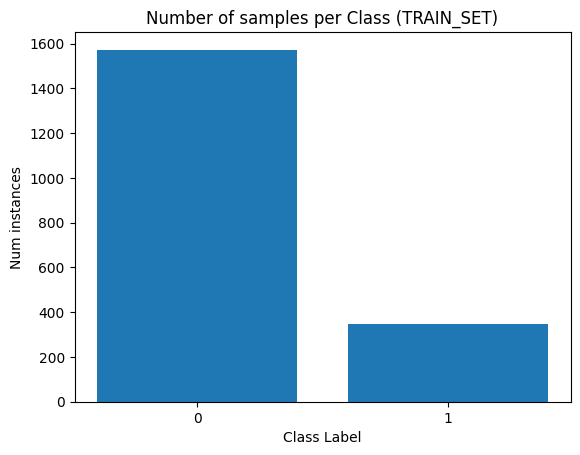

Number of samples per class ( TRAIN_SET ):  {'0': 1573, '1': 347}


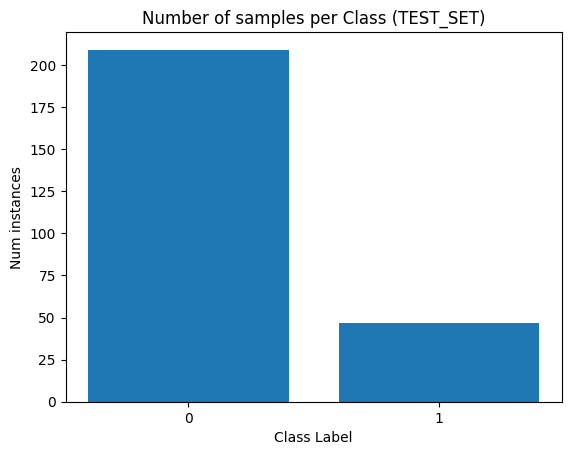

Number of samples per class ( TEST_SET ):  {'0': 209, '1': 47}


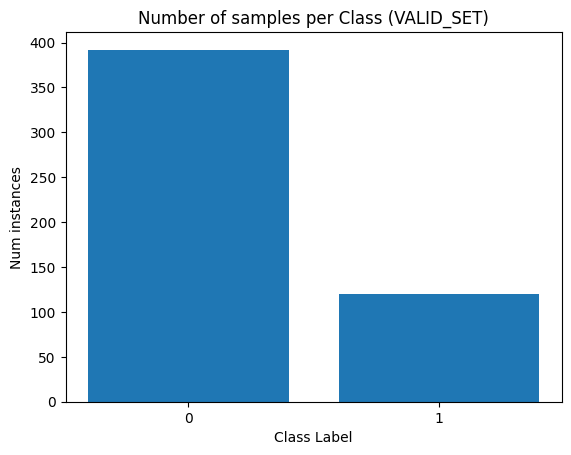

Number of samples per class ( VALID_SET ):  {'0': 392, '1': 120}


In [ ]:
from google.colab import auth
from googleapiclient.discovery import build

#To authenticate the user that run the script in order to use the correct path
auth.authenticate_user()
drive_service = build('drive', 'v3')

#Get user information
about = drive_service.about().get(fields='user').execute()
user_email = about['user']['emailAddress']
script_owner = False

if user_email =="rocco.iul2000@gmail.com":
  script_owner = True
  #Run the .ipynb file
  %run '/content/drive/MyDrive/Colab Notebooks/DatasetLoader.ipynb'
  %run '/content/drive/MyDrive/Colab Notebooks/ModelArchitecture1.ipynb'
  %run '/content/drive/MyDrive/Colab Notebooks/TrainModel.ipynb'
else:
  %run '/content/drive/MyDrive/LinkToOncoVision/DatasetLoader.ipynb'
  %run '/content/drive/MyDrive/LinkToOncoVision/ModelArchitecture1.ipynb'
  %run '/content/drive/MyDrive/LinkToOncoVision/TrainModel.ipynb'

# Genetic Algorithm (1° approach)
Our solutions has the following configuration (more detail in code below):
> [ learning_rate, batch_size, num_epoch, optimizer_type ]

Our **objective function**:
> max w * accuracy+(1-w) * recall where w=0.4

We convert our problem in minimization problem, therefore:
> min -w * accuracy-(1-w) * recall

Our **valuation function** is equal to objective funtion.

# Fitness function
Our **fitness function** is:
> fitness(x) = f(x)/∑ f(j) where j ∈ P-{x} and P represents the population

We get the fitness value from a csv file

In [ ]:
!pip install pygad
import pygad
import csv
import random
import numpy as np
import math
import pandas as pd

#This parameters are required by PyGAD
def fitness_function_calculator(ga_instance, solution, solution_idx):
  file_path = ""
  if script_owner:
    file_path = "/content/drive/MyDrive/SE4AI/ActualPopulation.csv"
  else:
    file_path = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/ActualPopulation.csv"

  flag = False
  fitness_value = 0
  with open(file_path, "r", newline="") as csvfile:
    reader = csv.reader(csvfile)
    next(reader) #Jump the first row (contains the file header)
    for row in reader:
      #Convert the values in the correct format
      learning_rate = float(row[0])
      batch_size = int(float(row[1]))
      num_epoch = int(float(row[2]))
      optimizer = int(float(row[3]))
      value = float(row[4])

      if learning_rate==solution[0] and batch_size==solution[1] and num_epoch==solution[2] and optimizer==solution[3]:
        flag = True
        fitness_value = value
        break

  if flag:
    return fitness_value
  else:
    print("Row not found!")
    return 0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 4.7 MB/s eta 0:00:00


# Initial population
We evaluate the initial population and store their fitness value in a csv file

In [ ]:
def fun_on_start(ga_instance):
  population = ga_instance.population
  population_list = population.tolist()

  to_write = []
  for solution in population_list:
    #batch_size
    size = 0
    match solution[1]:
      case 1:
        size = 32
      case 2:
        size = 64
      case 3:
        size = 128
      case _:
        size = 32

    #num_epoch
    epoch = 0
    match solution[2]:
      case 1:
        epoch = 64
      case 2:
        epoch = 96
      case 3:
        epoch = 128
      case _:
        epoch = 64

    #Train the model
    acc, pre, rec, f1 = start_process(bool_mlflow=False, learning_rate=solution[0], batch_size=size, num_epoch=epoch, opt=solution[3])
    fitness_value = (0.4*acc)+(0.6*rec)
    app = []
    app.extend(solution)
    app.append(fitness_value)
    app.append(acc)
    app.append(pre)
    app.append(rec)
    app.append(f1)

    to_write.append(app)

  #Store the solutions evaluations
  if script_owner:
    file_path1 = "/content/drive/MyDrive/SE4AI/ActualPopulation.csv"
    file_path2 = "/content/drive/MyDrive/SE4AI/AllSolutions.csv"
  else:
    file_path1 = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/ActualPopulation.csv"
    file_path2 = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/AllSolutions.csv"

  with open(file_path1, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["learning_rate","batch_size","num_epoch","optimizer","fitness_value","accuracy","precision","recall","f1"])
    writer.writerows(to_write)

  with open(file_path2, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["learning_rate","batch_size","num_epoch","optimizer","fitness_value","accuracy","precision","recall","f1"])
    writer.writerows(to_write)

# Tournament selection
At each tournament, we will select K=30 solutions

We will apply the tournament 20 times to obtain M=20 parents who will attend the crossover step.

In [ ]:
def my_tournament_selection(fitness_values,required_number,ga_instance):
  population = ga_instance.population
  population_list = population.tolist()

  winners = []
  winners_index = []
  for i in range(required_number):

    selected_indices = np.random.choice(np.arange(len(population_list)), size=3, replace=False) #replace=False -> in this way we don't select the same individual more then one time

    selected_individuals = [] #to store the selected individuals
    selected_individuals_fitness = [] #to store the relative fitness value

    for index in selected_indices:
      selected_individuals.append(population_list[index])
      selected_individuals_fitness.append(fitness_values[index])

    #Select the tournement winner
    winner_value = np.amax(selected_individuals_fitness)

    #Find its position
    winner_position = selected_individuals_fitness.index(winner_value)

    winner = selected_individuals[winner_position]

    #Record the winner
    winners.append(winner)

    #Record its index in the population (required by PyGAD)
    winner_position_in_population = population_list.index(winner)
    winners_index.append(winner_position_in_population)

    #To delete the winner from the population we'll set its fitness value to -inf. In this way it can't win the next tournements
    fitness_values[winner_position_in_population] = -math.inf

  #Transform them in numpy array because it is required by PyGAD
  winners_numpy = np.array(winners)
  winners_index_numpy = np.array(winners_index)

  return winners_numpy, winners_index_numpy

# Assessment of solutions
**After the mutation step** we will evalutate the solutions and store their fitness value in a csv file.

If we obtain a solution that has the same configuration of another solution stored in "AllSolutions.csv", we do not retrain the model as there is a high probability that the solutions have the same performance (in this way we reduce the time consumption)

In [ ]:
def fun_on_generation(ga_instance):
  population = ga_instance.population
  population_list = population.tolist()

  to_write = [] #To store the solutions of the actual population
  to_add = [] #To store the new solutions in AllSolutions.csv

  #Check if this solution already exists. In this way we don't train this model (less time consumption)
  file_path = ""
  if script_owner:
    file_path = "/content/drive/MyDrive/SE4AI/AllSolutions.csv"
  else:
    file_path = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/AllSolutions.csv"

  for solution in population_list:

    flag = False
    to_store = None
    with open(file_path, "r", newline="") as csvfile:
      reader = csv.reader(csvfile)
      next(reader) #Jump the first row (contains the file header)
      for row in reader:
        #Convert the values in the correct format
        learning_rate = float(row[0])
        batch_size = int(float(row[1]))
        num_epoch = int(float(row[2]))
        optimizer = int(float(row[3]))
        value = float(row[4])
        acc = float(row[5])
        pre = float(row[6])
        rec = float(row[7])
        f1 = float(row[8])

        if learning_rate==solution[0] and batch_size==solution[1] and num_epoch==solution[2] and optimizer==solution[3]:
          flag = True
          to_store = [learning_rate, batch_size, num_epoch, optimizer, value, acc, pre, rec, f1]
          break

    if flag:
      #We have already a same solution, therefore we store the configuration in ActualPopulation.csv
      to_write.append(to_store)
    else:
      #It's a new solution, therefore we must define and train a model

      #batch_size
      size = 0
      match solution[1]:
        case 1:
          size = 32
        case 2:
          size = 64
        case 3:
          size = 128
        case _:
          size = 32

      #num_epoch
      epoch = 0
      match solution[2]:
        case 1:
          epoch = 64
        case 2:
          epoch = 96
        case 3:
          epoch = 128
        case _:
          epoch = 64

      acc, pre, rec, f1 = start_process(bool_mlflow=False, learning_rate=solution[0], batch_size=size, num_epoch=epoch, opt=solution[3])
      fitness_value = (0.4*acc)+(0.6*rec)
      app = []
      app.extend(solution)
      app.append(fitness_value)
      app.append(acc)
      app.append(pre)
      app.append(rec)
      app.append(f1)

      #In this case we store the solution both in the AllSolutions and in the ActualPopulation (it's a new solution)
      to_write.append(app)
      to_add.append(app)

  file_path2 = ""
  if script_owner:
    file_path2 = "/content/drive/MyDrive/SE4AI/ActualPopulation.csv"
  else:
    file_path2 = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/ActualPopulation.csv"

  with open(file_path, "a", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(to_add)

  with open(file_path2, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["learning_rate","batch_size","num_epoch","optimizer","fitness_value","accuracy","precision","recall","f1"])
    writer.writerows(to_write)


# Genetich Algorithm

Train our model without the GA (to check its performance)
Insert the experiment name:firstDraftFirstApproach
START TRAINING STEP
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [1] Loss: 0.5542
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [2] Loss: 0.4907
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [3] Loss: 0.6718
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [4] Loss: 0.5483
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [5] Loss: 0.4086
Start VALIDATION STEP
Accuracy:  0.759765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [6] Loss: 0.6290
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [7] Loss: 0.6161
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [8] Loss: 0.5050
Start VALIDATION STEP
Accuracy:  0.75390625 ; Precision:  0.2 ; Recall:  0.016666666666666666 ; F1:  0.03076923076923077
Epoch [9] Loss: 0.6187
Start VALIDATION STEP
Accuracy:  0.767578125 ; Precision:  0.5714285714285714 ; Recall:  0.03333333333333333 ; F1:  0.06299212598425197
Epoch [10] Loss: 0.4950
Start VALIDATION STEP
Accuracy:  0.7734375 ; Precision:  0.75 ; Recall:  0.05 ; F1:  0.09375000000000001
Epoch [11] Loss: 0.6224
Start VALIDATION STEP
Accuracy:  0.7734375 ; Precision:  0.6111111111111112 ; Recall:  0.09166666666666666 ; F1:  0.15942028985507245
Epoch [12] Loss: 0.5445
Start VALIDATION STEP
Accuracy:  0.779296875 ; Precision:  0.6842105263157895 ; Recall:  0.10833333333333334 ; F1:  0.18705035971223025
Epoch [13] Loss: 0.4863
Start VALIDATION STEP
Accuracy:  0.77734375 ; Precision:  0.8 ; Recall:  0.06666666666666667 ; F1:  0.12307692307692308
Epoch [14] Loss: 0.4558
Start VALIDATION S

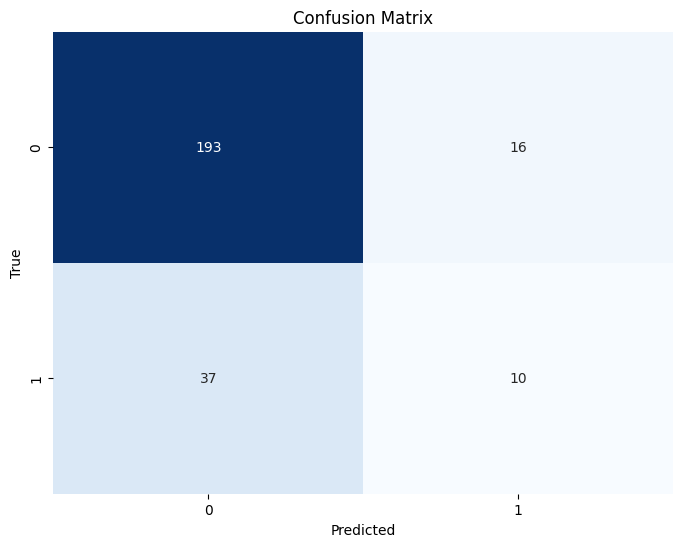

TP:  10  TN:  193  FP:  16  FN: 37
Device prima addestrare il modello:  cuda
Il modello si trova sulla GPU.
Ottimizzatore NO in GPU
START TRAINING STEP
Start VALIDATION STEP
Accuracy:  0.234375 ; Precision:  0.234375 ; Recall:  1.0 ; F1:  0.379746835443038
Epoch [1] Loss: 0.7142
Start VALIDATION STEP
Accuracy:  0.234375 ; Precision:  0.234375 ; Recall:  1.0 ; F1:  0.379746835443038
Epoch [2] Loss: 0.7115
Start VALIDATION STEP
Accuracy:  0.234375 ; Precision:  0.234375 ; Recall:  1.0 ; F1:  0.379746835443038
Epoch [3] Loss: 0.7083
Start VALIDATION STEP
Accuracy:  0.234375 ; Precision:  0.234375 ; Recall:  1.0 ; F1:  0.379746835443038
Epoch [4] Loss: 0.6977
Start VALIDATION STEP
Accuracy:  0.763671875 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [5] Loss: 0.6902
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [6] Loss: 0.6783
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [7] Loss: 0.6664
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [8] Loss: 0.6536
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [9] Loss: 0.6269
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [10] Loss: 0.5797
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [11] Loss: 0.5803
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [12] Loss: 0.5563
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [13] Loss: 0.5360
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [14] Loss: 0.5976
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [15] Loss: 0.4435
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [16] Loss: 0.4601
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [17] Loss: 0.5202
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [18] Loss: 0.6777
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [19] Loss: 0.6966
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [20] Loss: 0.5811
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [21] Loss: 0.5862
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [22] Loss: 0.6999
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [23] Loss: 0.6049
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [24] Loss: 0.5750
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [25] Loss: 0.5718
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [26] Loss: 0.5706
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [27] Loss: 0.6016
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [28] Loss: 0.6325
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [29] Loss: 0.6974
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [30] Loss: 0.6045
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [31] Loss: 0.4750
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [32] Loss: 0.6040
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [33] Loss: 0.6184
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Train step stopped at epoch  34  because the model doesn't improve!
The best model and optimizer configuration was achieved at the  1  epoch
The best accuracy:  0.234375  best recall:  1.0 best loss:  0.7141551375389099
Finished Training!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation metrics in TEST set:
Accuracy:  0.81640625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Device prima addestrare il modello:  cuda
Il modello si trova sulla GPU.
Ottimizzatore NO in GPU
START TRAINING STEP
Start VALIDATION STEP
Accuracy:  0.234375 ; Precision:  0.234375 ; Recall:  1.0 ; F1:  0.379746835443038
Epoch [1] Loss: 941.0748
Start VALIDATION STEP
Accuracy:  0.759765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [2] Loss: 1.9126
Start VALIDATION STEP
Accuracy:  0.640625 ; Precision:  0.19811320754716982 ; Recall:  0.175 ; F1:  0.18584070796460175
Epoch [3] Loss: 0.9288
Start VALIDATION STEP
Accuracy:  0.751953125 ; Precision:  0.26666666666666666 ; Recall:  0.03333333333333333 ; F1:  0.05925925925925926
Epoch [4] Loss: 0.7349
Start VALIDATION STEP
Accuracy:  0.7421875 ; Precision:  0.3 ; Recall:  0.075 ; F1:  0.12
Epoch [5] Loss: 0.6140
Start VALIDATION STEP
Accuracy:  0.755859375 ; Precision:  0.2727272727272727 ; Recall:  0.025 ; F1:  0.04580152671755725
Epoch

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [14] Loss: 0.5249
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [15] Loss: 0.5766
Start VALIDATION STEP
Accuracy:  0.751953125 ; Precision:  0.29411764705882354 ; Recall:  0.041666666666666664 ; F1:  0.072992700729927
Epoch [16] Loss: 0.6199
Start VALIDATION STEP
Accuracy:  0.763671875 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [17] Loss: 0.5097
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [18] Loss: 0.5981
Start VALIDATION STEP
Accuracy:  0.763671875 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [19] Loss: 0.5349
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [20] Loss: 0.5110
Start VALIDATION STEP
Accuracy:  0.76171875 ; Precision:  0.3333333333333333 ; Recall:  0.016666666666666666 ; F1:  0.031746031746031744
Epoch [21] Loss: 0.6034
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [22] Loss: 0.5932
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [23] Loss: 0.5262
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [24] Loss: 0.6134
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [25] Loss: 0.4862
Start VALIDATION STEP
Accuracy:  0.763671875 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [26] Loss: 0.6205
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [27] Loss: 0.6969
Start VALIDATION STEP
Accuracy:  0.744140625 ; Precision:  0.17647058823529413 ; Recall:  0.025 ; F1:  0.04379562043795621
Epoch [28] Loss: 0.7147
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [29] Loss: 0.5858
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [30] Loss: 0.7145
Start VALIDATION STEP
Accuracy:  0.763671875 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [31] Loss: 0.5690
Start VALIDATION STEP
Accuracy:  0.763671875 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [32] Loss: 0.5615
Start VALIDATION STEP
Accuracy:  0.763671875 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [33] Loss: 0.4478
Start VALIDATION STEP
Accuracy:  0.763671875 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Train step stopped at epoch  34  because the model doesn't improve!
The best model and optimizer configuration was achieved at the  1  epoch
The best accuracy:  0.234375  best recall:  1.0 best loss:  941.0748291015625
Finished Training!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation metrics in TEST set:
Accuracy:  0.81640625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Device prima addestrare il modello:  cuda
Il modello si trova sulla GPU.
Ottimizzatore NO in GPU
START TRAINING STEP
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [1] Loss: 4.0199
Start VALIDATION STEP
Accuracy:  0.76953125 ; Precision:  1.0 ; Recall:  0.016666666666666666 ; F1:  0.03278688524590164
Epoch [2] Loss: 93.2686
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [3] Loss: 2048.1228
Start VALIDATION STEP
Accuracy:  0.763671875 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [4] Loss: 4.3639
Start VALIDATION STEP
Accuracy:  0.236328125 ; Precision:  0.23483365949119372 ; Recall:  1.0 ; F1:  0.38034865293185416
Epoch [5] Loss: 21.0855
Start VALIDATION STEP
Accuracy:  0.443359375 ; Precision:  0.2727272727272727 ; Recall:  0.825 ; F1:  0.40993788819875776
Epoch [6] Loss: 17.7729
Start VALIDATION STEP
Accuracy:  0.630859375 ; Precision:  0.30726256983240224 ; Recall:  0.4583333333333333 ; F1:  0.3678929765886288
Epoch [7] Loss: 10.4165
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [8] Loss: 36.6887
Start VALIDATION STEP
Accuracy:  0.236328125 ; Precision:  0.23483365949119372 ; Recall:  1.0 ; F1:  0.38034865293185416
Epoch [9] Loss: 8.5387
Start VALIDATION STEP
Accuracy:  0.666015625 ; Precision:  0.33112582781456956 ; Recall:  0.4166666666666667 ; F1:  0.3690036900369004
Epoch [10] Loss: 6.9981
Start VALIDATION STEP
Accuracy:  0.23828125 ; Precision:  0.23529411764705882 ; Recall:  1.0 ; F1:  0.38095238095238093
Epoch [11] Loss: 21.2304
Start VALIDATION STEP
Accuracy:  0.76171875 ; Precision:  0.375 ; Recall:  0.025 ; F1:  0.04687500000000001
Epoch [12] Loss: 11.4515
Start VALIDATION STEP
Accuracy:  0.75390625 ; Precision:  0.4166666666666667 ; Recall:  0.125 ; F1:  0.1923076923076923
Epoch [13] Loss: 12.3239
Start VALIDATION STEP
Accuracy:  0.759765625 ; Precision:  0.36363636363636365 ; Recall:  0.03333333333333333 ; F1:  0.061068702290076333
Epoch [14] Loss: 6.4266
Start VALIDATION STEP
Ac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [18] Loss: 26.9731
Start VALIDATION STEP
Accuracy:  0.63671875 ; Precision:  0.2708333333333333 ; Recall:  0.325 ; F1:  0.2954545454545454
Epoch [19] Loss: 3.3033
Start VALIDATION STEP
Accuracy:  0.625 ; Precision:  0.2777777777777778 ; Recall:  0.375 ; F1:  0.3191489361702128
Epoch [20] Loss: 5.2046
Start VALIDATION STEP
Accuracy:  0.232421875 ; Precision:  0.2328767123287671 ; Recall:  0.9916666666666667 ; F1:  0.37717908082408874
Epoch [21] Loss: 33.8876
Start VALIDATION STEP
Accuracy:  0.513671875 ; Precision:  0.26199261992619927 ; Recall:  0.5916666666666667 ; F1:  0.36317135549872126
Epoch [22] Loss: 5.3323
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [23] Loss: 12.7323
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [24] Loss: 18.9436
Start VALIDATION STEP
Accuracy:  0.76171875 ; Precision:  0.375 ; Recall:  0.025 ; F1:  0.04687500000000001
Epoch [25] Loss: 5.2305
Start VALIDATION STEP
Accuracy:  0.728515625 ; Precision:  0.1935483870967742 ; Recall:  0.05 ; F1:  0.07947019867549669
Epoch [26] Loss: 1.8507
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [27] Loss: 3.8063
Start VALIDATION STEP
Accuracy:  0.234375 ; Precision:  0.234375 ; Recall:  1.0 ; F1:  0.379746835443038
Epoch [28] Loss: 17.9738
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [29] Loss: 13.9872
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [30] Loss: 7.4407
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [31] Loss: 4.7484
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [32] Loss: 2.6507
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [33] Loss: 1.2220
Start VALIDATION STEP
Accuracy:  0.751953125 ; Precision:  0.34782608695652173 ; Recall:  0.06666666666666667 ; F1:  0.1118881118881119
Epoch [34] Loss: 0.6508
Start VALIDATION STEP
Accuracy:  0.765625 ; Precision:  0.5 ; Recall:  0.008333333333333333 ; F1:  0.01639344262295082
Train step stopped at epoch  35  because the model doesn't improve!
The best model and optimizer configuration was achieved at the  2  epoch
The best accuracy:  0.76953125  best recall:  0.016666666666666666 best loss:  93.26860046386719
Finished Training!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation metrics in TEST set:
Accuracy:  0.81640625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Row not found!
Row not found!
Device prima addestrare il modello:  cuda
Il modello si trova sulla GPU.
Ottimizzatore NO in GPU
START TRAINING STEP
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [1] Loss: 0.6581
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [2] Loss: 0.6584
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [3] Loss: 0.6551
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [4] Loss: 0.5722
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [5] Loss: 0.5519
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [6] Loss: 0.5592
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [7] Loss: 0.6488
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [8] Loss: 0.6952
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [9] Loss: 0.5916
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [10] Loss: 0.6126
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [11] Loss: 0.5007
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [12] Loss: 0.6137
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [13] Loss: 0.5021
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [14] Loss: 0.6213
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [15] Loss: 0.5118
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [16] Loss: 0.5273
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [17] Loss: 0.5439
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [18] Loss: 0.6354
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [19] Loss: 0.5515
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [20] Loss: 0.4828
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [21] Loss: 0.5708
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [22] Loss: 0.5064
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [23] Loss: 0.5647
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [24] Loss: 0.5788
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [25] Loss: 0.6530
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [26] Loss: 0.4312
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [27] Loss: 0.6373
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [28] Loss: 0.5733
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [29] Loss: 0.6743
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [30] Loss: 0.6464
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [31] Loss: 0.6305
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [32] Loss: 0.6385
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [33] Loss: 0.6543
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Train step stopped at epoch  34  because the model doesn't improve!
The best model and optimizer configuration was achieved at the  1  epoch
The best accuracy:  0.765625  best recall:  0 best loss:  0.6581230759620667
Finished Training!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation metrics in TEST set:
Accuracy:  0.81640625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Device prima addestrare il modello:  cuda
Il modello si trova sulla GPU.
Ottimizzatore NO in GPU
START TRAINING STEP
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [1] Loss: 0.6049
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [2] Loss: 0.3373
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [3] Loss: 0.5645
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [4] Loss: 0.5238
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [5] Loss: 0.5310
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [6] Loss: 0.5219
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [7] Loss: 0.4534
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [8] Loss: 0.5662
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [9] Loss: 0.5654
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [10] Loss: 0.4917
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [11] Loss: 0.5306
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [12] Loss: 0.6485
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [13] Loss: 0.6001
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [14] Loss: 0.4794
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [15] Loss: 0.5507
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [16] Loss: 0.5085
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [17] Loss: 0.7050
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [18] Loss: 0.6135
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [19] Loss: 0.5023
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [20] Loss: 0.5495
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [21] Loss: 0.5220
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [22] Loss: 0.4636
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [23] Loss: 0.5457
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [24] Loss: 0.7228
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [25] Loss: 0.4756
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [26] Loss: 0.5183
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [27] Loss: 0.7039
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [28] Loss: 0.4829
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [29] Loss: 0.4803
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [30] Loss: 0.5822
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [31] Loss: 0.5491
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [32] Loss: 0.6204
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [33] Loss: 0.5165
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [34] Loss: 0.5230
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [35] Loss: 0.5526
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [36] Loss: 0.4987
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [37] Loss: 0.4806
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [38] Loss: 0.5844
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [39] Loss: 0.5033
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [40] Loss: 0.4843
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [41] Loss: 0.5212
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [42] Loss: 0.6467
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [43] Loss: 0.4914
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [44] Loss: 0.5789
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [45] Loss: 0.6515
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [46] Loss: 0.4940
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [47] Loss: 0.5567
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [48] Loss: 0.6852
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [49] Loss: 0.4818
Start VALIDATION STEP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.765625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Train step stopped at epoch  50  because the model doesn't improve!
The best model and optimizer configuration was achieved at the  1  epoch
The best accuracy:  0.765625  best recall:  0 best loss:  0.6048671007156372
Finished Training!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation metrics in TEST set:
Accuracy:  0.81640625 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0


invalid literal for int() with base 10: '1.0'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pygad/pygad.py", line 1669, in cal_pop_fitness
    fitness = self.fitness_func(self, sol, sol_idx)
  File "<ipython-input-3-d9164465bdad>", line 23, in fitness_function_calculator
    row_app = [float(row[0]),int(row[1]),int(row[2]),int(row[3]),float(row[4])] #Convert the values in the correct format
ValueError: invalid literal for int() with base 10: '1.0'
ERROR:pygad.pygad:invalid literal for int() with base 10: '1.0'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pygad/pygad.py", line 1669, in cal_pop_fitness
    fitness = self.fitness_func(self, sol, sol_idx)
  File "<ipython-input-3-d9164465bdad>", line 23, in fitness_function_calculator
    row_app = [float(row[0]),int(row[1]),int(row[2]),int(row[3]),float(row[4])] #Convert the values in the correct format
ValueError: invalid literal for int() with base 10: '1.0'
ERRO

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pygad/pygad.py", line 1669, in cal_pop_fitness
    fitness = self.fitness_func(self, sol, sol_idx)
  File "<ipython-input-3-d9164465bdad>", line 23, in fitness_function_calculator
    row_app = [float(row[0]),int(row[1]),int(row[2]),int(row[3]),float(row[4])] #Convert the values in the correct format
ValueError: invalid literal for int() with base 10: '1.0'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-1020420dc18a>", line 37, in <cell line: 37>
    ga_instance.run()
  File "/usr/local/lib/python3.10/dist-packages/pygad/pygad.py", line 2073, in run
    self.last_generation_fitness = self.cal_pop_fitness()
  File "/usr/local/lib/python3.10/dist-packages/pygad/pygad.

TypeError: ignored

In [ ]:
#Define and train out model
print("Train our model without the GA (to check its performance)")
start_process(bool_mlflow=True, learning_rate=0.001, batch_size=64, num_epoch=64, opt=1)

print("Start Genetich Algorithm!")
max_num_generation = 3
fitness = fitness_function_calculator
M = 2 #20 #number of parents to selection step
fitness_func = fitness_function_calculator
population_size = 3 #100
chromosomes_size = 4 #learning rate, batch size, num epoch, optimizer
# batch size: 1=32, 2=64, 3=128 ;
# num epoch: 1=64, 2=96, 3=128
# optimizer: 1=Adam, 2=Adadelta, 3=Nadam

genes_range = [{'low': 0.001, 'high': 0.1}, {'low': 1, 'high': 3}, {'low': 1, 'high': 3}, {'low': 1, 'high': 3}]

k = 3 #30 #number of individuals that partecipate to the tournement


ga_instance = pygad.GA(num_generations = max_num_generation,
                       num_parents_mating = M,
                       fitness_func = fitness,
                       sol_per_pop = population_size,
                       num_genes = chromosomes_size,
                       gene_type =[float, int, int, int],
                       gene_space = genes_range,
                       parent_selection_type = my_tournament_selection,
                       crossover_type = "single_point", #One-Point Crossover
                       mutation_type = "random", #Random Resetting -> set a random value within the range
                       mutation_by_replacement = True, #replace the gene by the new randomly generated value
                       mutation_probability = 0.5, #The probability that a gene must exceed in order to be modified
                       stop_criteria= "saturate_40", #Stop criteria: stop the GA if there isn't an improvement after 40 consecutive steps
                       on_start = fun_on_start,
                       on_generation = fun_on_generation
                       )
ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution: ", solution)
print("Fitness value of the best solution = ", solution_fitness)

file_path = ""
if script_owner:
  file_path = "/content/drive/MyDrive/SE4AI/Model/EvaluationGAFirstApproach/BestSolutionGA1.csv"
else:
  file_path = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/EvaluationGAFirstApproach/BestSolutionGA1.csv"

to_write = []
to_write.extend(solution)
to_write.append(solution_fitness)
with open(file_path, "w", newline="") as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(["learning_rate","batch_size","num_epoch","optimizer","fitness_value"])
  writer.writerow(to_write)